## Research various skew related topics

In [1]:
import zipfile
import glob
import pandas as pd
import numpy as np

from argparse import ArgumentParser
from argparse import RawDescriptionHelpFormatter
import sys
import os
if  not './' in sys.path:
    sys.path.append('./')
if  not '../' in sys.path:
    sys.path.append('../')

from barchartacs import build_db
from barchartacs import db_info
import plotly.graph_objs as go
from plotly.offline import  init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.tools as tls
from plotly.graph_objs.layout import Font,Margin
from IPython import display

import datetime
import io
from tqdm import tqdm,tqdm_notebook
from barchartacs import pg_pandas as pg
import mibian
import py_vollib
import importlib
from py_vollib import black
from py_vollib.black import implied_volatility
import ipdb
import traceback
import pandas_datareader.data as pdr

# importlib.reload(build_db)

/Users/bperlman1/Virtualenvs3/dashrisk4/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
SYMBOL_TO_RESEARCH = 'ES'

In [4]:
def fetch_history(symbol,dt_beg,dt_end):
    df = pdr.DataReader(symbol, 'yahoo', dt_beg, dt_end)
    # move index to date column, sort and recreate index
    df['date'] = df.index
    df = df.sort_values('date')
    df.index = list(range(len(df)))
    # make adj close the close
    df['unadj_close'] = df.Close
    df['Close'] = df['Adj Close']
    df = df.drop(['Adj Close'],axis=1)
    cols = df.columns.values 
    cols_dict = {c:c[0].lower() + c[1:] for c in cols}
    df = df.rename(columns = cols_dict)
    
    df['trade_date'] = df.date.apply(lambda v:int(v.strftime('%Y%m%d')))
    df['year'] = df.date.apply(lambda v: v.year)
    df['month'] = df.date.apply(lambda v: v.month)
    df['day'] = df.date.apply(lambda v: v.day)
    return df


In [5]:
dt_end = datetime.datetime.now()
dt_beg = dt_end - datetime.timedelta(365*5)
df_spy = fetch_history('SPY',dt_beg,dt_end)

In [6]:
df_spy['pct'] = df_spy.close.pct_change()[1:]
df_spy['mean_pct'] = df_spy.pct.rolling(30).mean()
df_spy['std_pct'] = df_spy.pct.rolling(30).std()
df_spy = df_spy.iloc[30:]
df_spy['skew'] = df_spy.apply(lambda r:((r.pct - r.mean_pct)/r.std_pct)**3,axis=1)

In [7]:
df_spy.tail(35)

,high,low,open,close,volume,date,unadj_close,trade_date,year,month,day,pct,mean_pct,std_pct,skew
1222,326.730011,325.519989,326.160004,326.649994,48473300.0,2020-01-09,326.649994,20200109,2020,1,9,0.006781,0.001560,0.004890,1.217141
1223,327.459991,325.200012,327.290009,325.709991,53029300.0,2020-01-10,325.709991,20200110,2020,1,10,-0.002878,0.001388,0.004954,-0.638521
1224,327.959991,325.920013,326.390015,327.950012,47086800.0,2020-01-13,327.950012,20200113,2020,1,13,0.006877,0.001469,0.005025,1.246856
1225,328.619995,326.839996,327.470001,327.450012,62832800.0,2020-01-14,327.450012,20200114,2020,1,14,-0.001525,0.001542,0.004963,-0.235882
1226,329.019989,327.260010,327.350006,328.190002,72056600.0,2020-01-15,328.190002,20200115,2020,1,15,0.002260,0.001900,0.004587,0.000482
1227,330.920013,329.450012,329.700012,330.920013,54050300.0,2020-01-16,330.920013,20200116,2020,1,16,0.008318,0.002401,0.004433,2.379190
1228,332.179993,330.850006,331.700012,331.950012,95846000.0,2020-01-17,331.950012,20200117,2020,1,17,0.003113,0.002299,0.004378,0.006415
1229,332.179993,330.820007,330.899994,331.299988,77742400.0,2020-01-21,331.299988,20200121,2020,1,21,-0.001958,0.002174,0.004446,-0.802984
1230,332.950012,331.170013,332.239990,331.339996,48914900.0,2020-01-22,331.339996,20200122,2020,1,22,0.000121,0.001873,0.004260,-0.069660
1231,332.170013,329.410004,330.630005,331.720001,51963000.0,2020-01-23,331.720001,20200123,2020,1,23,0.001147,0.002017,0.004156,-0.009160


### important global variables

In [8]:

DEBUG_IT=False
opttab = 'sec_schema.options_table'
futtab = 'sec_schema.underlying_table'


In [231]:
def plotly_plot(df_in,x_column,plot_title=None,
                y_left_label=None,y_right_label=None,
                bar_plot=False,figsize=(16,10),
                number_of_ticks_display=20,
                yaxis2_cols=None,
                x_value_labels=None):
    ya2c = [] if yaxis2_cols is None else yaxis2_cols
    ycols = [c for c in df_in.columns.values if c != x_column]
    # create tdvals, which will have x axis labels
    td = list(df_in[x_column]) 
    nt = len(df_in)-1 if number_of_ticks_display > len(df_in) else number_of_ticks_display
    spacing = len(td)//nt
    tdvals = td[::spacing]
    tdtext = tdvals
    if x_value_labels is not None:
        tdtext = [x_value_labels[i] for i in tdvals]
    
    # create data for graph
    data = []
    # iterate through all ycols to append to data that gets passed to go.Figure
    for ycol in ycols:
        if bar_plot:
            b = go.Bar(x=td,y=df_in[ycol],name=ycol,yaxis='y' if ycol not in ya2c else 'y2')
        else:
            b = go.Scatter(x=td,y=df_in[ycol],name=ycol,yaxis='y' if ycol not in ya2c else 'y2')
        data.append(b)

    # create a layout
    layout = go.Layout(
        title=plot_title,
        xaxis=dict(
            ticktext=tdtext,
            tickvals=tdvals,
            tickangle=45,
            type='category'),
        yaxis=dict(
            title='y main' if y_left_label is None else y_left_label
        ),
        yaxis2=dict(
            title='y alt' if y_right_label is None else y_right_label,
            overlaying='y',
            side='right'),
        margin=Margin(
            b=100
        )        
    )

    fig = go.Figure(data=data,layout=layout)
    fig.update_layout(
        title={
            'text': plot_title,
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'})
    return fig


#### get all contracts in the options database

In [10]:
pga = db_info.get_db_info()
all_contracts = pga.get_sql(f"select distinct symbol from {opttab} where symbol~'^{SYMBOL_TO_RESEARCH}'").sort_values('symbol').values.reshape(-1)
len(all_contracts)

  sec_db


84

In [21]:
def get_big_bars(commod,threshold_price,threshold_perc):
    sql_big_bars = f"""
    with 
    f1 as (
        select substring(symbol,1,2) commod, symbol,settle_date,(high-low)/open hilo_perc,
        (close-open)/open open_close_perc
        from {futtab} 
        where symbol like '{commod}%%' and open_interest>0 and volume>0 and open > {threshold_price}
    ),
    f2 as (
        select commod, symbol, max(hilo_perc) hilo_perc_max from f1
        group by commod,symbol
    ),
    f3 as (
        select f1.symbol, f1.settle_date, f1.hilo_perc from f1
        join f2 on f1.symbol=f2.symbol
    )
    select * from f3 where hilo_perc >= {threshold_perc}
    order by hilo_perc desc
    """
    df_big_bars = pga.get_sql(sql_big_bars)
    return df_big_bars

In [38]:
df_gold_big_bars = get_big_bars('GC',1000,.05)

Distribution of days where (High - Low)/Open >= .05 and open>=1000
Total days = 114


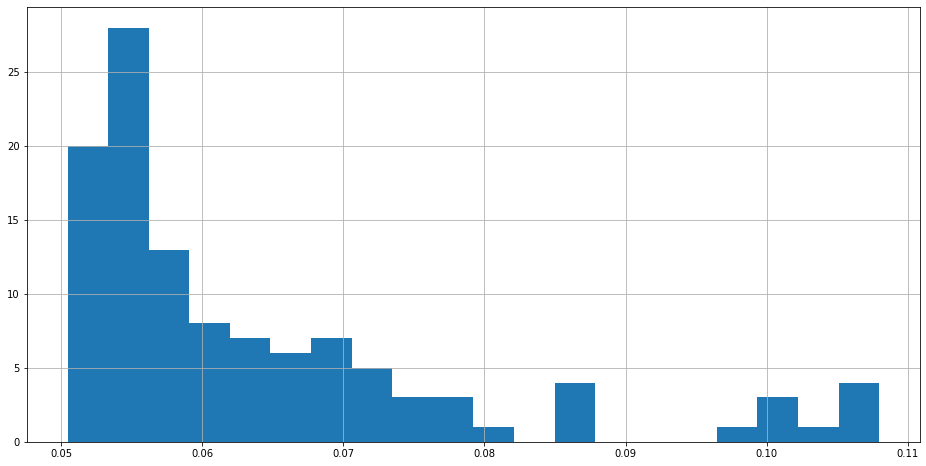

In [39]:
df_gold_big_bars.hilo_perc.hist(bins=20,figsize=(16,8))
print(f"Distribution of days where (High - Low)/Open >= .05 and open>=1000")
print(f"Total days = {len(df_gold_big_bars)}")

In [40]:
dfgbb = df_gold_big_bars.sort_values('settle_date')
dfgbb.index = list(range(len(dfgbb)))
dfgbb['num'] = dfgbb.index
iplot(plotly_plot(df_in=dfgbb[['num','hilo_perc']],
                  x_column='num',bar_plot=True,
                  plot_title='(high-low)/open >= .05 and open >= 1000',
                  x_value_labels=dfgbb.settle_date.values))


In [41]:
 def get_large_perc_changes(commod,threshold_price,threshold_perc):
    sql_large_perc_changes = f"""
    with 
    f1 as (
        select symbol,
    --    substring(symbol,1,2) commod,
        concat(substring(symbol,1,2),
        substring(symbol,4,2),
        substring(symbol,3,1)) sym,
        settle_date,open,high,low,close,
        (close-open)/open open_close_perc
        from {futtab} 
        where symbol like '{commod}%%' and open_interest>0 and volume>0 and open > {threshold_price}
        and (close-open)/open <= {threshold_perc}
    ),
    f2 as (
        select  settle_date,min(sym) sym
        from f1
        group by settle_date
    )
    select f1.sym,f1.settle_date,open,high,low,close,f1.open_close_perc
    from f1
    join f2 on f1.sym = f2.sym and f1.settle_date = f2.settle_date
    order by f1.settle_date 
    """
    df_large_perc_changes = pga.get_sql(sql_large_perc_changes)
    return df_large_perc_changes


In [42]:
df_gold_large_pct_chgs = get_large_perc_changes('GC',1000,-.045)
display.display(df_gold_large_pct_chgs)
df_silver_large_pct_chgs = get_large_perc_changes('SI',10,-.07)
display.display(df_silver_large_pct_chgs)

,sym,settle_date,open,high,low,close,open_close_perc
0,GC12M,20110824,1848.5,1862.4,1762.6,1762.6,-0.046470
1,GC11U,20110923,1737.3,1737.3,1637.5,1637.5,-0.057445
2,GC13J,20130415,1478.2,1487.4,1338.0,1360.6,-0.079556
3,GC13M,20130620,1348.1,1348.1,1275.4,1285.9,-0.046139
4,GC20H,20200228,1640.3,1642.5,1564.1,1564.1,-0.046455


,sym,settle_date,open,high,low,close,open_close_perc
0,SI11K,20110505,39.215,39.520,34.440,36.231,-0.076093
1,SI11K,20110511,38.830,39.380,35.025,35.509,-0.085527
2,SI11V,20110824,42.140,42.290,39.178,39.178,-0.070290
3,SI11U,20110922,39.620,39.620,35.550,36.538,-0.077789
4,SI11U,20110923,36.470,36.530,30.051,30.051,-0.176008
5,SI12K,20110928,32.900,32.900,30.010,30.188,-0.082432
6,SI12F,20111117,33.965,33.965,31.325,31.521,-0.071956
7,SI13K,20130415,25.940,26.045,22.515,23.361,-0.099422
8,SI16X,20161111,18.705,18.800,17.335,17.364,-0.071692
9,SI20H,20200228,17.690,17.805,16.340,16.387,-0.073657


In [158]:
pga.get_sql(f"select  max(settle_date) from {futtab} where substring(symbol,1,2)='CL'")

,max
0,20200302


In [160]:
vol_oi_dates_old = pga.get_sql(f"select distinct settle_date from {opttab} order by settle_date desc").settle_date.unique()
vol_oi_dates_new = np.append(vol_oi_dates_old[1:],[-1])
df_vol_oi_dates = pd.DataFrame({'settle_date':vol_oi_dates_old,'new_settle_date':vol_oi_dates_new})


In [163]:
def acs_adjust_vol_oi_date(df_with_wrong_vol_oi_date):
#     bad_date_list = np.sort(df_with_wrong_vol_oi_date.settle_date.unique())[::-1]
#     good_date_list = bad_date_list[1:]
#     good_date_list = np.append(good_date_list,[-1])
#     df_dates = pd.DataFrame({'settle_date':bad_date_list,'new_settle_date':good_date_list})
#     df_new = df_with_wrong_vol_oi_date.copy()
    df_new = df_with_wrong_vol_oi_date.merge(df_vol_oi_dates,how='inner',on='settle_date')
    df_new.settle_date = df_new.new_settle_date
    df_new = df_new[df_new.settle_date>-1]
    return df_new


In [94]:
sql_cl_opt_vol_by_date = f"""
select strike,pc,volume,open_interest  from sec_schema.options_table 
where settle_date = 20200302 and symbol = 'CLJ20'
order by strike,pc 
"""
df_sql_cl_opt_vol_by_date = pga.get_sql(sql_cl_opt_vol_by_date)
# df_sql_cl_opt_vol_by_date[(df_sql_cl_opt_vol_by_date.pc=='C') & (df_sql_cl_opt_vol_by_date.volsum>0)]
df_sql_cl_opt_vol_by_date[(df_sql_cl_opt_vol_by_date.pc=='C') ].head(40)


,strike,pc,volume,open_interest
1,21.5,C,0,2
2,22.0,C,0,1
3,22.5,C,0,1
4,23.0,C,0,1
5,24.0,C,0,1
7,25.0,C,2,2
8,25.5,C,3,1
12,27.0,C,0,0
15,28.0,C,0,0
17,28.5,C,0,0


In [142]:
nn = np.array([3,1,4])
nn = np.sort(nn)
nn[::-1]

array([4, 3, 1])

In [155]:

sql_cl_opt_vol_by_date = f"""
select settle_date,sum(volume) volsum, sum(open_interest) oi_sum from sec_schema.options_table 
where settle_date >= 20200220 and symbol like 'CL%%'
group by settle_date
order by settle_date desc
"""
df_volsum = pga.get_sql(sql_cl_opt_vol_by_date)


In [164]:
acs_adjust_vol_oi_date(df_volsum)

,settle_date,volsum,oi_sum,new_settle_date
0,20200228,291272,2097752,20200228
1,20200227,316346,99572,20200227
2,20200226,202528,1960809,20200226
3,20200225,159727,1914747,20200225
4,20200224,153643,1879440,20200224
5,20200221,120900,1852108,20200221
6,20200220,111082,1823665,20200220
7,20200219,113880,1806850,20200219


In [110]:
b = df_volsum.settle_date.values
print(b)
b = b[1:]
print(np.append(b,[-1]))

[20200302 20200228 20200227 20200226 20200225 20200224 20200221 20200220]
[20200228 20200227 20200226 20200225 20200224 20200221 20200220       -1]


In [173]:
sql_cl_opts_vol_by_put_call = f"""
with
f1 as (
    select settle_date,pc,symbol,sum(volume) vol_sum_by_pc from sec_schema.options_table
    where settle_date>=20200101 and symbol like 'CL%%' and volume>0
    group by settle_date, pc,symbol
    order by settle_date, pc,symbol
),
f2 as
(
    select settle_date,symbol,sum(vol_sum_by_pc) vol_sum_by_symbol
    from f1
    group by settle_date,symbol
),
f3 as
(
    select f1.*, f2.vol_sum_by_symbol from f1
    join f2 on f1.settle_date  = f2.settle_date and f1.symbol = f2.symbol
    order by f2.vol_sum_by_symbol desc,f1.settle_date,f1.pc
)
select * from f3
"""
df_cl_opts_vol_by_put_call = pga.get_sql(sql_cl_opts_vol_by_put_call)


In [174]:
df_cl_opts_vol_by_put_call_C = df_cl_opts_vol_by_put_call[df_cl_opts_vol_by_put_call.pc=='C']
df_cl_opts_vol_by_put_call_C = df_cl_opts_vol_by_put_call_C.rename(columns={'vol_sum_by_pc':'vol_sum_C'})
df_cl_opts_vol_by_put_call_C = df_cl_opts_vol_by_put_call_C[['settle_date','symbol','vol_sum_C','vol_sum_by_symbol']]
df_cl_opts_vol_by_put_call_C.index = list(range(len(df_cl_opts_vol_by_put_call_C)))
df_cl_opts_vol_by_put_call_P = df_cl_opts_vol_by_put_call[df_cl_opts_vol_by_put_call.pc=='P']
df_cl_opts_vol_by_put_call_P = df_cl_opts_vol_by_put_call_P.rename(columns={'vol_sum_by_pc':'vol_sum_P'})
df_cl_opts_vol_by_put_call_P = df_cl_opts_vol_by_put_call_P[['settle_date','symbol','vol_sum_P']]
df_cl_opts_vol_by_put_call_P.index = list(range(len(df_cl_opts_vol_by_put_call_P)))
df_cl_opts_vol = df_cl_opts_vol_by_put_call_C.merge(df_cl_opts_vol_by_put_call_P,how='inner',
                                                 on=['settle_date','symbol'])
df_cl_opts_vol['pc_vol_diff'] = df_cl_opts_vol.vol_sum_C - df_cl_opts_vol.vol_sum_P
df_cl_opts_vol = acs_adjust_vol_oi_date(df_cl_opts_vol)
display.display(df_cl_opts_vol[['settle_date','symbol','vol_sum_C','vol_sum_P','pc_vol_diff','vol_sum_by_symbol']].head(20))


,settle_date,symbol,vol_sum_C,vol_sum_P,pc_vol_diff,vol_sum_by_symbol
0,20200108,CLG20,113253,96419,16834,209672.0
1,20200108,CLH20,74577,45366,29211,119943.0
2,20200108,CLJ20,15235,13857,1378,29092.0
3,20200108,CLM20,16210,12757,3453,28967.0
4,20200108,CLK20,4202,5671,-1469,9873.0
5,20200108,CLZ20,4762,3488,1274,8250.0
6,20200108,CLN20,5697,2378,3319,8075.0
7,20200108,CLU20,2539,2295,244,4834.0
8,20200108,CLZ21,2251,200,2051,2451.0
9,20200108,CLM21,1450,601,849,2051.0


In [175]:
df_cl_opts_vol_sum_by_date = df_cl_opts_vol[['settle_date','vol_sum_C','vol_sum_P','vol_sum_by_symbol']].groupby('settle_date').sum()
df_cl_opts_vol_sum_by_date = df_cl_opts_vol_sum_by_date.sort_values('settle_date',ascending=False)
df_cl_opts_vol_sum_by_date

,vol_sum_C,vol_sum_P,vol_sum_by_symbol
settle_date,,,
20200228,131277,158639,289916.0
20200227,142650,173176,315826.0
20200226,96404,106024,202428.0
20200225,66243,93147,159390.0
20200224,72363,81079,153442.0
20200221,52419,68072,120491.0
20200220,51100,59174,110274.0
20200219,52030,61643,113673.0
20200218,44642,46100,90742.0


In [196]:
sql_opt_expir = f"""
with
f1 as
(
    select symbol,concat(substring(symbol,1,2),substring(symbol,4,2),substring(symbol,3,1)) as sym,settle_date
    from sec_schema.options_table
    where settle_date>=20160101 and symbol like 'CL%%' and volume>0
)
select * from f1
"""
df_sql_opt_expir = pga.get_sql(sql_opt_expir)


In [207]:
df_sql_opt_expir_last_day = df_sql_opt_expir[['settle_date','symbol','sym']].groupby(['symbol','sym'],as_index=False).max()
df_sql_opt_expir_last_day = df_sql_opt_expir_last_day[df_sql_opt_expir_last_day.sym<='CL20G']
df_sql_opt_expir_last_day


,symbol,sym,settle_date
0,CLF17,CL17F,20161215
1,CLF18,CL18F,20171214
2,CLF19,CL19F,20181214
3,CLF20,CL20F,20191216
5,CLG16,CL16G,20160114
6,CLG17,CL17G,20170117
7,CLG18,CL18G,20180117
8,CLG19,CL19G,20190116
9,CLG20,CL20G,20200115
11,CLH16,CL16H,20160217


In [193]:
sql_cl_opts_vol_by_date = f"""
with
f1 as (
    select settle_date,volume from sec_schema.options_table
    where settle_date>=20160101 and symbol like 'CL%%' and volume>0
),
f2 as
(
    select settle_date,sum(volume) vol_sum
    from f1
    group by settle_date
    order by settle_date
)
select * from f2
"""
df_cl_opts_vol_date = pga.get_sql(sql_cl_opts_vol_by_date)


In [218]:
fig = go.Figure()

# Add scatter trace for line
fig.add_trace(go.Scatter(
    x=["2015-02-01", "2015-02-02", "2015-02-03", "2015-02-04", "2015-02-05",
       "2015-02-06", "2015-02-07", "2015-02-08", "2015-02-09", "2015-02-10",
       "2015-02-11", "2015-02-12", "2015-02-13", "2015-02-14", "2015-02-15",
       "2015-02-16", "2015-02-17", "2015-02-18", "2015-02-19", "2015-02-20",
       "2015-02-21", "2015-02-22", "2015-02-23", "2015-02-24", "2015-02-25",
       "2015-02-26", "2015-02-27", "2015-02-28"],
    y=[-14, -17, -8, -4, -7, -10, -12, -14, -12, -7, -11, -7, -18, -14, -14,
       -16, -13, -7, -8, -14, -8, -3, -9, -9, -4, -13, -9, -6],
    mode="lines",
    name="temperature"
))

# Add shape regions
fig.update_layout(
    shapes=[
        # 1st highlight during Feb 4 - Feb 6
        dict(
            type="rect",
            # x-reference is assigned to the x-values
            xref="x",
            # y-reference is assigned to the plot paper [0,1]
            yref="paper",
            x0="2015-02-04",
            y0=0,
            x1="2015-02-06",
            y1=1,
            fillcolor="LightSalmon",
            opacity=0.5,
            layer="below",
            line_width=0,
        ),
        # 2nd highlight during Feb 20 - Feb 23
        dict(
            type="rect",
            xref="x",
            yref="paper",
            x0="2015-02-20",
            y0=0,
            x1="2015-02-22",
            y1=1,
            fillcolor="LightSalmon",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
    ]
)

fig.show()

In [229]:
?plotly_plot

In [233]:
df_cl_opts_vol_date2 = df_cl_opts_vol_date.copy()
df_cl_opts_vol_date2['is_ld'] = df_cl_opts_vol_date2.settle_date.apply(
    lambda d:1 if d in df_sql_opt_expir_last_day.settle_date.unique() else 0)
df_cl_opts_vol_date2['yyyy'] = df_cl_opts_vol_date2.settle_date.apply(lambda d:int(str(d)[0:4]))   
for y in np.sort(df_cl_opts_vol_date2.yyyy.unique()):
    df_yyyy = df_cl_opts_vol_date2[df_cl_opts_vol_date2.yyyy==y]
    fig = plotly_plot(
            df_in=df_yyyy[['settle_date','vol_sum']],
            x_column='settle_date',
            plot_title=f'Option Volume {y} (Expiration in Orange)',
            y_left_label='Total Options Volume Per Day'
        )
    
    df_yyyy['is_ld_end'] = df_yyyy.is_ld.shift(1)
    df_yyyy['is_ld_beg'] = df_yyyy.is_ld.shift(-1)
    ld_beg = df_yyyy[df_yyyy.is_ld_beg==1].settle_date.values
    ld_end = df_yyyy[df_yyyy.is_ld_end==1].settle_date.values

    ld_shapes = []
    for i in range(min(len(ld_beg),len(ld_end))):
        ld_shape = dict(
            type="rect",
            # x-reference is assigned to the x-values
            xref="x",
            # y-reference is assigned to the plot paper [0,1]
            yref="paper",
            x0=ld_beg[i],
            y0=0,
            x1=ld_end[i],
            y1=1,
            fillcolor="LightSalmon",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
        ld_shapes.append(ld_shape)

    fig.update_layout(shapes=ld_shapes)
    iplot(fig)


In [61]:
sql_cl_opts_oi_by_put_call = f"""
with
f1 as (
    select settle_date,pc,symbol,sum(open_interest) oi_sum_by_pc from sec_schema.options_table
    where settle_date>=20200225 and symbol like 'CL%%' and open_interest>0
    group by settle_date, pc,symbol
    order by settle_date, pc,symbol
),
f2 as
(
    select settle_date,symbol,sum(oi_sum_by_pc) oi_sum_by_symbol
    from f1
    group by settle_date,symbol
),
f3 as
(
    select f1.*, f2.oi_sum_by_symbol from f1
    join f2 on f1.settle_date  = f2.settle_date and f1.symbol = f2.symbol
    order by f2.oi_sum_by_symbol desc,f1.settle_date,f1.pc
)
select * from f3
"""
df_cl_opts_oi_by_put_call = pga.get_sql(sql_cl_opts_oi_by_put_call)




In [56]:
df_cl_opts_oi_by_put_call_C = df_cl_opts_oi_by_put_call[df_cl_opts_oi_by_put_call.pc=='C']
df_cl_opts_oi_by_put_call_C = df_cl_opts_oi_by_put_call_C.rename(columns={'oi_sum_by_pc':'oi_sum_C'})
df_cl_opts_oi_by_put_call_C = df_cl_opts_oi_by_put_call_C[['settle_date','symbol','oi_sum_C','oi_sum_by_symbol']]
df_cl_opts_oi_by_put_call_P = df_cl_opts_oi_by_put_call[df_cl_opts_oi_by_put_call.pc=='P']
df_cl_opts_oi_by_put_call_P = df_cl_opts_oi_by_put_call_P.rename(columns={'oi_sum_by_pc':'oi_sum_P'})
df_cl_opts_oi_by_put_call_P = df_cl_opts_oi_by_put_call_P[['settle_date','symbol','oi_sum_P']]
df_cl_opts_oi = df_cl_opts_oi_by_put_call_C.merge(df_cl_opts_oi_by_put_call_P,how='inner',
                                                 on=['settle_date','symbol'])
df_cl_opts_oi['pc_oi_diff'] = df_cl_opts_oi.oi_sum_C - df_cl_opts_oi.oi_sum_P
display.display(df_cl_opts_oi[['settle_date','symbol','oi_sum_C','oi_sum_P','pc_oi_diff','oi_sum_by_symbol']].head(20))


,settle_date,symbol,oi_sum_C,oi_sum_P,pc_oi_diff,oi_sum_by_symbol
0,20200227,CLM20,296008,234753,61255,530761.0
1,20200226,CLM20,290970,229927,61043,520897.0
2,20200225,CLM20,289853,229943,59910,519796.0
3,20200227,CLZ20,228737,159101,69636,387838.0
4,20200226,CLZ20,228434,158002,70432,386436.0
5,20200225,CLZ20,227025,156710,70315,383735.0
6,20200227,CLJ20,196321,184278,12043,380599.0
7,20200226,CLJ20,191686,181242,10444,372928.0
8,20200225,CLJ20,188698,172930,15768,361628.0
9,20200227,CLK20,102765,113080,-10315,215845.0


In [63]:
df_cl_opts_oi_sum_by_date = df_cl_opts_oi[['settle_date','oi_sum_by_symbol']].groupby('settle_date').sum()
df_cl_opts_oi_sum_by_date = df_cl_opts_oi_sum_by_date.sort_values('oi_sum_by_symbol',ascending=False)
df_cl_opts_oi_sum_by_date

,oi_sum_by_symbol
settle_date,
20200227,1959099.0
20200226,1913037.0
20200225,1877730.0
20200228,99566.0


In [57]:
df_cl_opts_oi.to_csv('temp_folder/LO_open_interest_by_day.csv',index=False)

In [57]:
sql_20181025 = f"""
select * from {opttab}  where symbol~'^{SYMBOL_TO_RESEARCH}' and settle_date='20181025' 
"""
print(sql_20181025)
df_20181025 = pga.get_sql(sql_20181025)
print(len(df_20181025))



select * from sec_schema.options_table  where symbol~'^ES' and settle_date='20181025' 

2386


array(['ESZ18', 'ESH19', 'ESM19', 'ESU19'], dtype=object)

In [67]:
df_20181025[df_20181025.symbol=='ESH19']#[['symbol','settle_date']].drop_duplicates().groupby('symbol').count()

,symbol,strike,pc,settle_date,open,high,low,close,adj_close,volume,open_interest
696,ESH19,1150.0,C,20181025,0.0,1545.00,1544.90,1545.00,1545.00,0,0
697,ESH19,1150.0,P,20181025,0.0,0.85,0.65,0.85,0.85,0,1434
698,ESH19,1175.0,C,20181025,0.0,1520.00,1519.90,1520.00,1520.00,0,0
699,ESH19,1175.0,P,20181025,0.9,0.95,0.90,0.95,0.95,0,732
700,ESH19,1200.0,C,20181025,0.0,1495.00,1494.90,1495.00,1495.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1361,ESH19,4350.0,P,20181025,0.0,1655.10,1655.00,1655.00,1655.00,0,0
1362,ESH19,4375.0,C,20181025,0.0,0.10,0.10,0.10,0.10,0,0
1363,ESH19,4375.0,P,20181025,0.0,1680.10,1680.00,1680.00,1680.00,0,0
1364,ESH19,4400.0,C,20181025,0.0,0.10,0.10,0.10,0.10,0,40


In [68]:
df_iv_final[df_iv_final.symbol=='ESH19']

,close_x,close_y,contract_num,dte,iv,pc,settle_date,strike,symbol,moneyness,atm_iv,vol_skew
24432,NaN,2934.0,2,172,0.284874,NaN,20180924,2053.800,ESH19,-0.30,0.121410,0.1635
24433,NaN,2934.0,2,172,0.256676,NaN,20180924,2200.500,ESH19,-0.25,0.121410,0.1353
24434,NaN,2934.0,2,172,0.230327,NaN,20180924,2347.200,ESH19,-0.20,0.121410,0.1089
24435,NaN,2934.0,2,172,0.204052,NaN,20180924,2493.900,ESH19,-0.15,0.121410,0.0826
24436,NaN,2934.0,2,172,0.176784,NaN,20180924,2640.600,ESH19,-0.10,0.121410,0.0554
...,...,...,...,...,...,...,...,...,...,...,...,...
25237,NaN,2413.5,2,84,0.183778,NaN,20181221,2775.525,ESH19,0.15,0.233682,-0.0499
25238,NaN,2413.5,2,84,0.185289,NaN,20181221,2896.200,ESH19,0.20,0.233682,-0.0484
25239,NaN,2413.5,2,84,0.190318,NaN,20181221,3016.875,ESH19,0.25,0.233682,-0.0434
25240,NaN,2413.5,2,84,0.193749,NaN,20181221,3137.550,ESH19,0.30,0.233682,-0.0399


### graph skew

In [15]:
def create_skew_per_date_df(df):
    '''
    Find the first settle_date whose count of rows is equal to max count of rows.
    '''
    # get the first symbol (which should be the only symbol)
    contract = df.symbol.unique()[0]
    # get just that symbol's data
    df12 = df[df.symbol==contract]
    df_counts = df12[['settle_date','moneyness']].groupby('settle_date',as_index=False).count()
    max_count = df_counts.moneyness.max()
    first_max_count_settle_date = df_counts[df_counts.moneyness==max_count].iloc[0].settle_date
    
    df_ret = df12[df12.settle_date==first_max_count_settle_date][['moneyness']]
    all_settle_dates = sorted(df_counts.settle_date.unique())
    for settle_date in all_settle_dates:
        df_temp = df12[df12.settle_date==settle_date][['moneyness','vol_skew']]
        df_ret = df_ret.merge(df_temp,on='moneyness',how='outer')
        df_ret = df_ret.rename(columns={'vol_skew':str(settle_date)})
    df_ret = df_ret.sort_values('moneyness')
    df_ret.moneyness = df_ret.moneyness.round(4)
    return df_ret


In [16]:
def graph_skew(df_iv_final,do_plot=False):
    '''
    Graph skew for ONLY ONE symbol.
    If df_iv_final contains more than one symbol, we will only graph the first symbol in the DataFrames    
    '''
    # get the first symbol (which should be the only symbol)
    contract = df_iv_final.symbol.unique()[0]
    # get just that symbol's data and only days that have sufficient skew data
    dft = df_iv_final[df_iv_final.symbol==contract]
    dft_count = dft[['settle_date','symbol']].groupby('settle_date',as_index=False).count()
    valid_settle_dates = dft_count[dft_count.symbol>2].settle_date.unique()
    dft = dft[dft.settle_date.isin(valid_settle_dates)]
    dfp = create_skew_per_date_df(dft)
    
    settle_dates = sorted([c for c in dfp.columns.values if c != 'moneyness'])
    splits = list(np.arange(5,len(settle_dates),5))
    settle_date_groups = np.split(np.array(settle_dates),splits)
    ret_figs = []
    for sdg in settle_date_groups:
        sdg_sorted = [str(c) for c in sorted(sdg)]
        cols = ['moneyness']+list(sdg_sorted)
        dfp_sub = dfp[cols]
        t = f'{contract} {sdg[0]} - {sdg[-1]}' 
        f = plotly_plot(dfp_sub,x_column='moneyness',plot_title=t,y_left_label='vol skew')
        ret_figs.append(f)
        if do_plot:
            iplot(f)
    return ret_figs

In [17]:
my_list = [1, 2, 3, 4, 5, 
              6, 7] 
  
# How many elements each 
# list should have 
n = 4 
  
# using list comprehension 
final = [my_list[i * n:(i + 1) * n] for i in range((len(my_list) + n - 1) // n )]  
print (final)

[[1, 2, 3, 4], [5, 6, 7]]


#### Do the same plots as above, but using a grid

In [18]:
def graph_skew_subplots(df):
    rfs = graph_skew(df)
    n = 4   
    # using list comprehension 
    rfs_groups = [rfs[i*n:(i + 1)*n] for i in range((len(rfs) + n - 1) // n )]  
    for rfs_group in rfs_groups:
        iplot(graph_skew_subplot_quad(rfs_group))
    
def graph_skew_subplot_quad(rfs):
    '''
    Use subplots to output the results of the method graph_skew above
    '''
    rows = 2#len(rfs)//2
    f1 = tls.make_subplots(rows=rows, cols=2,  
        shared_yaxes=False, 
        subplot_titles=[rfs[i]['layout'].title for i in range(len(rfs))],
        horizontal_spacing=0.09,
        vertical_spacing=0.11,                       
        print_grid=False)

    pl_width=900
    pl_height=800 
    title = 'Skew plots<br>'

    f1['layout'].update(title=title,                                 
        font= Font(family="Open Sans, sans-serif"),
        showlegend=True,     
        hovermode='x',  
        autosize=True,       
        width=pl_width,       
        height=pl_height,
        plot_bgcolor='#EFECEA', 
        bargap=0.05,
        margin=Margin(
                      l=45,
                      r=15,
                      b=55,
                      t=50
        )
    )    

    for i in range(len(rfs)):
        x = int(i/2) + 1
        y = i % 2 + 1
        f = rfs[i]
        l = f.layout
        
        try:
            yaxis = f'yaxis{i+1}'
            xaxis = f'xaxis{i+1}'
            if i < 10:
                yaxis = yaxis.replace('1','') 
                xaxis = xaxis.replace('1','') 
            f1['layout'].update({xaxis:l.xaxis})
            f1['layout'].update({yaxis:l.yaxis})
            gname = f'chart {x,y}'#rfs[i]['layout'].title
            for d in f.data:
                data_y = f'y{i+1}'.replace('1','') 
                d['yaxis']=data_y
                d['legendgroup'] =  gname
                d['name'] = f"{gname} {d.name}"
                f1.append_trace(d,x,y)
        except Exception as e:
            print(f'graph_skew_subplots ERRORS: {str(e)}')
    return f1
# iplot(f1)


In [30]:
df_iv_final = pd.read_csv('./temp_folder/df_iv_final_ES.csv')
df_iv_skew = pd.read_csv('./temp_folder/df_iv_skew_ES.csv')

In [31]:
etf = 'spy'
yyyymmdd_beg = df_iv_skew.settle_date.min() 
yyyymmdd_end = df_iv_skew.settle_date.max()
dt_beg = datetime.datetime(int(str(yyyymmdd_beg)[0:4]),int(str(yyyymmdd_beg)[4:6]),int(str(yyyymmdd_beg)[6:8]))
dt_end = datetime.datetime(int(str(yyyymmdd_end)[0:4]),int(str(yyyymmdd_end)[4:6]),int(str(yyyymmdd_end)[6:8]))
df_etf = fetch_history(etf,dt_beg,dt_end)
df_etf = df_etf.rename(columns={'trade_date':'settle_date'})

In [32]:
grid_plot=True
clist = [c for c in all_contracts if (c[:2]==f'{SYMBOL_TO_RESEARCH}') & (c[-2:]=='19')]
for c in clist:
    dft = df_iv_final[df_iv_final.symbol==c]
    if len(dft)<=0:
        print(f'no data for symbol {c}')
        continue
    if grid_plot:
        graph_skew_subplots(df_iv_final[df_iv_final.symbol==c])
    else:
        rls = graph_skew(df_iv_final[df_iv_final.symbol==c],do_plot=True)

### Use the implied vol skew dataframes to graph changes in vol skew vs price

In [33]:
y = 19
c = SYMBOL_TO_RESEARCH
df_year = df_iv_skew[(df_iv_skew.symbol.str.slice(0,2)==c) & (df_iv_skew.symbol.str.slice(-2,)==str(y))]
df_year['diff'] = df_year['-0.2'] - df_year['0.2']
df_year = df_year[['settle_date','diff']]
df_year = df_year.merge(df_etf[['settle_date','close']],on='settle_date',how='inner')
iplot(plotly_plot(df_year,x_column='settle_date',y_left_label='put skew',yaxis2_cols=['close'],y_right_label=f'{etf} close'))



/Users/bperlman1/Virtualenvs3/dashrisk3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [43]:
df_nan = df_iv_skew[(df_iv_skew['0.35'].isna()) & (df_iv_skew.settle_date>=20181020)]
print(f'len: {len(df_iv_skew)} nans:{len(df_nan)}')
df_nan.head(20)

len: 2266 nans:197


,-0.3,-0.25,-0.2,-0.15,-0.1,-0.05,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,symbol,settle_date
470,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESH19,20181025
479,0.1646,0.1382,0.1114,0.0842,0.0565,0.0286,0.0,-0.0249,-0.0360,-0.0292,-0.0175,-0.0044,0.0093,NaN,ESH19,20181107
480,0.1694,0.1414,0.1134,0.0859,0.0580,0.0293,0.0,-0.0270,-0.0366,-0.0284,-0.0158,-0.0025,0.0128,NaN,ESH19,20181108
499,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,-0.0356,NaN,NaN,ESH19,20181207
510,0.1288,0.1110,0.0921,0.0732,0.0522,0.0280,0.0,-0.0282,-0.0461,-0.0446,-0.0354,-0.0272,-0.0187,NaN,ESH20,20190923
511,0.1280,0.1093,0.0911,0.0722,0.0518,0.0277,0.0,-0.0294,-0.0500,-0.0504,-0.0425,-0.0325,-0.0254,NaN,ESH20,20190924
512,0.1290,0.1108,0.0921,0.0731,0.0524,0.0283,0.0,-0.0293,-0.0483,-0.0477,-0.0386,-0.0296,-0.0226,NaN,ESH20,20190925
513,0.1301,0.1110,0.0927,0.0735,0.0524,0.0286,0.0,-0.0295,-0.0486,-0.0480,-0.0389,-0.0301,-0.0224,NaN,ESH20,20190926
514,0.1285,0.1097,0.0910,0.0726,0.0520,0.0278,0.0,-0.0300,-0.0507,-0.0514,-0.0426,-0.0330,-0.0255,NaN,ESH20,20190927
515,0.1296,0.1108,0.0927,0.0738,0.0531,0.0288,0.0,-0.0305,-0.0503,-0.0485,-0.0387,-0.0280,-0.0186,NaN,ESH20,20190930


In [51]:
df_atm_vol = df_iv_final[df_iv_final.settle_date>=20181020][['settle_date','atm_iv']].drop_duplicates()
df_atm_vol.index = range(len(df_atm_vol))
df_atm_vol[df_atm_vol.settle_date==20181025]


,settle_date,atm_iv
3,20181025,0.182198


In [51]:
y = 19
c = SYMBOL_TO_RESEARCH
df_year = df_iv_skew[(df_iv_skew.symbol.str.slice(0,2)==c) & (df_iv_skew.symbol.str.slice(-2,)==str(y))]
df_year = df_year[['settle_date','-0.2','0.2']]
df_year = df_year.merge(df_etf[['settle_date','close']],on='settle_date',how='inner')
iplot(plotly_plot(df_year,x_column='settle_date',yaxis2_cols=['close'],y_right_label='uso close'))

In [52]:
def get_postgres_data(contract):
    osql = f"select * from {opttab} where symbol='{contract}';"
    dfo = pga.get_sql(osql)
    usql = f"select * from {futtab} where symbol='{contract}';"
    dfu = pga.get_sql(usql)
    # Merge options and futures data
    df = dfo.merge(dfu,how='inner',on=['symbol','settle_date'])
    # Get options expiration dates
    df_expiry_dates = dfo[['symbol','settle_date']].groupby('symbol',as_index=False).max()
    return df,df_expiry_dates

In [53]:
USE_PYVOL = True
def lam_pyvol(r):
    try:
        return implied_volatility.implied_volatility(r.close_x,r.close_y,r.strike,.02,r.dte/365, r.pc.lower())
    except:
        return -1
# lam_pyvol = lambda r:implied_volatility.implied_volatility(r.close_x,r.close_y,r.strike,.02,r.dte/365, r.pc.lower())
lam_mibian = lambda r:mibian.BS([r.close_y,r.strike,2,r.dte], callPrice=r.close_x).impliedVolatility

def get_implieds(df,df_expiry_dates,contract):
    df2 = df[['symbol','contract_num','pc','settle_date','strike','close_x','close_y']]
    df2 = df2[(((df2.pc=='C' )& (df2.strike>=df2.close_y)) | ((df2.pc=='P' ) & (df2.strike<df2.close_y)))  & (df2.symbol.str.contains(contract))]
    df2 = df2[df2.contract_num==2]
    phigh = df2.close_y.max()
    plow = df2.close_y.min()
    high_strike = round(phigh * 1.3)
    low_strike = round(plow * .7)
    df2 = df2[(df2.strike>=low_strike) & (df2.strike<=high_strike)]

    df9 = df2[df2.symbol==contract]
    df9 = df9.merge(df_expiry_dates.rename(columns={'settle_date':'expiry'}),on='symbol',how='inner')
    df9['syear'] = df9.settle_date.astype(str).str.slice(0,4).astype(int)
    df9['smon'] = df9.settle_date.astype(str).str.slice(4,6).astype(int)
    df9['sday'] = df9.settle_date.astype(str).str.slice(6,8).astype(int)
    df9['eyear'] = df9.expiry.astype(str).str.slice(0,4).astype(int)
    df9['emon'] = df9.expiry.astype(str).str.slice(4,6).astype(int)
    df9['eday'] = df9.expiry.astype(str).str.slice(6,8).astype(int)
    df9['sdatetime'] = df9.apply(lambda r:datetime.datetime(r.syear,r.smon,r.sday),axis=1)
    df9['edatetime'] = df9.apply(lambda r:datetime.datetime(r.eyear,r.emon,r.eday),axis=1)
    df9['dte'] = df9.edatetime - df9.sdatetime
    df9.dte = df9.dte.dt.days
    df9 = df9[['symbol','settle_date','pc','contract_num','strike','close_x','close_y','dte']]
    df10 = df9.iloc[:len(df9)].copy()
    df10.index = list(range(len(df10)))
    if USE_PYVOL:
        df10['iv'] = df10.apply(lam_pyvol,axis=1)
    else:
        n = 100
        for i in tqdm_notebook(np.arange(0,len(df10)-n,n)):
                df10.loc[i:i+n,'iv'] = df10.loc[i:i+n].apply(lam_mibian,axis=1)
        print(f'doing remaining {datetime.datetime.now()}')
        i = df10[df10.iv.isna()].index[0]
        df10.loc[i:,'iv'] = df10.loc[i:].apply(lam_mbian,axis=1)
        print(f'done with remaining {datetime.datetime.now()}')
    return df10



In [54]:
def get_even_moneyness_strikes(df10):
    # define amounts around the money which will help create strikes to add
    moneyness = np.arange(.7,1.4,.05).round(6)
    # define columns on which to execute groupby
#     gb_cols = ['symbol','settle_date','pc','contract_num','dte','close_y']
    gb_cols = ['symbol','settle_date','contract_num','dte','close_y']
    # define function used in groupby.apply to create strikes and iv's at those strikes
    #   where the strikes are an even amount from the money 
    #   (like .7, .8, ... 1, 1.1, 1.2, etc)
    def _add_even_moneyness_strikes(df):
        # get underlying from first row (the groupby makes them all the same)
        r = df.iloc[0]
        underlying = r.close_y
        # create new rows to append to df, using only the gb_cols
        df_ret1 = df.iloc[:len(moneyness)][gb_cols].copy()
        # add nan iv's !!!! MUST BE np.nan - NOT None
        df_ret1['iv'] = np.nan
        # add new strikes
        df_ret1['strike'] = moneyness * underlying
        # append the new strikes
        dfa = df.append(df_ret1,ignore_index=True,sort=True).copy()
        df_ret2 = dfa.sort_values(['symbol','settle_date','pc','strike'])
        df_ret2 = df_ret2.drop_duplicates(subset='strike')
        # set the index to the strike so that interpolate works
        df_ret2.index = df_ret2.strike
        # create interpolated iv's
        df_ret2['iv'] = df_ret2.iv.interpolate(method='polynomial', order=2)
        # reset the index
        df_ret2.index = list(range(len(df_ret2)))
        return df_ret2

    # start here
    df11 = df10.groupby(gb_cols).apply(_add_even_moneyness_strikes).copy()
    df11.index = list(range(len(df11)))
    df11['moneyness'] = df11.strike / df11.close_y
    df11.moneyness = df11.moneyness.round(4)

    df12 = df11[(df11.moneyness.isin(moneyness)) & (~df11.iv.isna())].copy()
    df12.moneyness  = df12.moneyness - 1
    df12.index = list(range(len(df12)))
    df12_atm = df12[df12.moneyness==0][['symbol','settle_date','pc','iv']]
    df12_atm = df12_atm.rename(columns={'iv':'atm_iv'})
    
    df12_atm = df12_atm.drop_duplicates()
    df12 = df12.merge(df12_atm,on=['symbol','settle_date','pc'],how='inner')
    df12.moneyness = df12.moneyness.round(4)
    df12['vol_skew'] = (df12.iv - df12.atm_iv).round(4)
    return df12



## END